In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import os

jar_name = "postgresql-42.6.0.jar"
jar_path = os.path.abspath(jar_name)

if not os.path.exists(jar_path):
    print(f"❌ Le fichier est toujours absent du dossier {os.getcwd()}")
else:
    print(f"✅ Fichier trouvé à : {jar_path}")

spark = SparkSession.builder \
    .appName("PostgresFinalTest") \
    .config("spark.jars", jar_path) \
    .config("spark.driver.extraClassPath", jar_path) \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

url = "jdbc:postgresql://localhost:5432/silver_data"
properties = {
        "user": "silver_user",
        "password": "silver_pass123", # Vérifiez bien ce mot de passe dans votre docker-compose
        "driver": "org.postgresql.Driver"
    }
    
# Charger les données depuis Postgres vers un nouveau DataFrame
df_bronze = spark.read.jdbc(url=url, table="bronze_data", properties=properties)

# Afficher les 5 premières lignes
df_bronze.show(5)
    

✅ Fichier trouvé à : /home/saida/Smart-LogiTrack/ml/notebooks/postgresql-42.6.0.jar


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/13 12:50:24 WARN Utils: Your hostname, DESKTOP-A9FN519, resolves to a loopback address: 127.0.1.1; using 172.30.212.146 instead (on interface eth0)
26/01/13 12:50:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
26/01/13 12:50:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/13 12:50:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       2| 2025-01-17 18:08:04|  2025-01-17 18:19:55|           NULL|          0.0|      NULL|              NULL|         161|    

In [2]:
print(df_bronze.count())

3475226


#### Supprimer les lignes avec valeurs NULL critiques

In [4]:
critical_columns = [
    "passenger_count", 
    "RatecodeID", 
    "store_and_fwd_flag",
    "congestion_surcharge",
    "Airport_fee"
]

rows_before = df_bronze.count()
df_silver = df_bronze.dropna(subset=critical_columns)
rows_after = df_silver.count()
print(f"Lignes supprimées (NULL critiques): {rows_before - rows_after:,}")

Lignes supprimées (NULL critiques): 540,149


In [5]:
total_rows = df_silver.count()
print("POURCENTAGE DE VALEURS MANQUANTES:")
for col_name in df_silver.columns:
    missing_count = df_silver.filter(col(col_name).isNull()).count()
    percentage = (missing_count / total_rows) * 100
    if percentage > 0:
        print(f"{col_name}: {percentage:.2f}%")

POURCENTAGE DE VALEURS MANQUANTES:


##### SUPPRESSION DES VALEURS ABERRANTES

In [6]:
rows_before = df_bronze.count()

df_silver = df_silver.filter(
    (col("trip_distance") >= 0.1) & (col("trip_distance") <= 50) &
    
    # Montants positifs
    (col("fare_amount") >= 2.5) & (col("fare_amount") < 200) &
    (col("total_amount") >= 3) & (col("total_amount") < 250) &
    
    
    (col("tip_amount") <= 100) &
    
    # Tolls: max $50
    (col("tolls_amount") <= 50) &
    
    # Nombre de passagers raisonnable
    (col("passenger_count") > 0) & (col("passenger_count") <= 6) &
    
    # Durée du trajet cohérente
    (unix_timestamp(col("tpep_dropoff_datetime")) > 
     unix_timestamp(col("tpep_pickup_datetime")))
)

rows_after = df_silver.count()
print(f"✓ Lignes supprimées (aberrantes): {rows_before - rows_after:,}")
print(f"✓ Lignes conservées: {rows_after:,} ({(rows_after/rows_before)*100:.2f}%)")

✓ Lignes supprimées (aberrantes): 668,408
✓ Lignes conservées: 2,806,818 (80.77%)


#### STANDARDISATION DES TYPES

#### convertir les colonnes categorielle en types appropries

In [7]:
df_silver = df_silver \
    .withColumn("VendorID", col("VendorID").cast(IntegerType())) \
    .withColumn("RatecodeID", col("RatecodeID").cast(IntegerType())) \
    .withColumn("payment_type", col("payment_type").cast(IntegerType())) \
    .withColumn("passenger_count", col("passenger_count").cast(IntegerType()))

#### valider les valeurs catégorielles

In [8]:
df_silver = df_silver.filter(
    col("VendorID").isin([1, 2]) &
    col("RatecodeID").isin([1, 2, 3, 4, 5, 6]) &
    col("payment_type").isin([0, 1, 2, 3, 4, 5]) &
    col("store_and_fwd_flag").isin(['Y', 'N'])
)

#### CREATION DE LA CIBLE

In [9]:
df_silver = df_silver.withColumn('trip_duration',
                   (unix_timestamp('tpep_dropoff_datetime')-unix_timestamp('tpep_pickup_datetime'))/60)

##### DISTRIBUTION DE LA CIBLE (trip_duration)

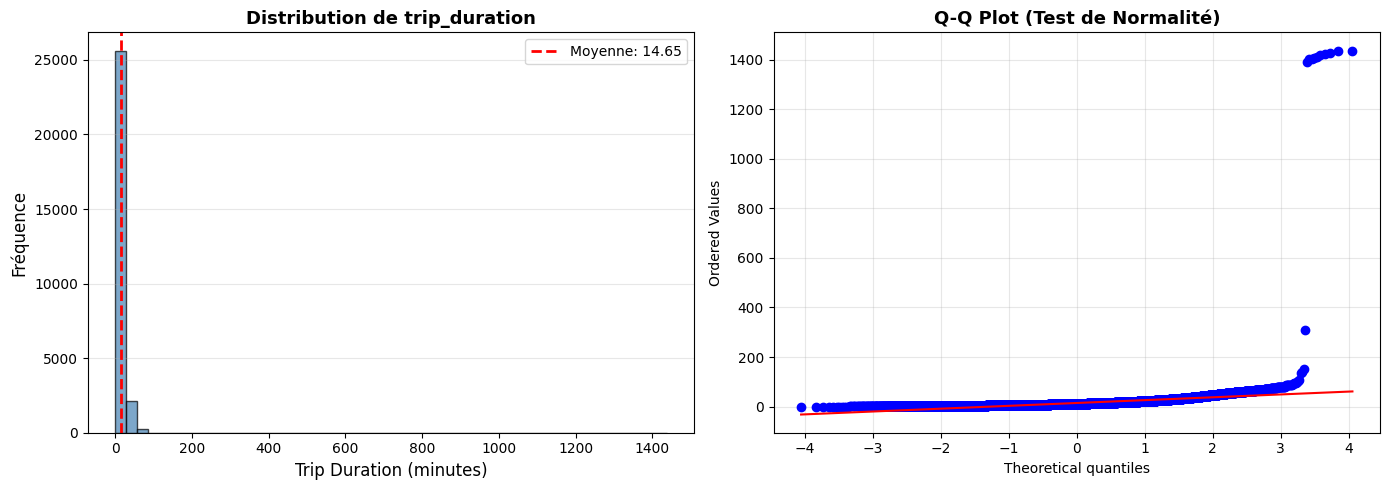

In [10]:
duration_sample = df_silver.select("trip_duration").sample(False, 0.01, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(duration_sample['trip_duration'], bins=50, color='steelblue', 
             alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Trip Duration (minutes)', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution de trip_duration', fontsize=13, fontweight='bold')
axes[0].axvline(duration_sample['trip_duration'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Moyenne: {duration_sample["trip_duration"].mean():.2f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

from scipy import stats
stats.probplot(duration_sample['trip_duration'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Test de Normalité)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
df_silver.describe().show()

26/01/13 12:57:11 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+-------------------+--------------------+
|summary|           VendorID|   passenger_count|     trip_distance|         RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|       trip_duration|
+-------+-------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+----------------

In [12]:
stats = df_silver.select("improvement_surcharge").describe()
print("\n📈 Statistiques de base:")
stats.show()


📈 Statistiques de base:


+-------+---------------------+
|summary|improvement_surcharge|
+-------+---------------------+
|  count|              2767823|
|   mean|   0.9999963870522067|
| stddev| 0.001900772486440...|
|    min|                  0.0|
|    max|                  1.0|
+-------+---------------------+



#### DÉTECTION DES OUTLIERS - TRIP DURATION

In [13]:
stats = df_silver.select("trip_duration").describe()
print("\n📈 Statistiques de base:")
stats.show()


📈 Statistiques de base:


+-------+--------------------+
|summary|       trip_duration|
+-------+--------------------+
|  count|             2767823|
|   mean|  14.684613846332645|
| stddev|  28.509726249605773|
|    min|0.016666666666666666|
|    max|   5626.316666666667|
+-------+--------------------+



In [14]:
advanced_stats = df_silver.select(
    count("trip_duration").alias("count"),
    min("trip_duration").alias("min"),
    max("trip_duration").alias("max"),
    avg("trip_duration").alias("mean"),
    stddev("trip_duration").alias("std_dev"),
    variance("trip_duration").alias("variance"),
    skewness("trip_duration").alias("skewness"),
    kurtosis("trip_duration").alias("kurtosis")
).collect()[0]

In [15]:
print(f"""
📊 STATISTIQUES AVANCÉES:
   • Nombre de trajets: {advanced_stats['count']:,}
   • Minimum: {advanced_stats['min']:.2f} minutes
   • Maximum: {advanced_stats['max']:.2f} minutes ({advanced_stats['max']/60:.2f} heures)
   • Moyenne: {advanced_stats['mean']:.2f} minutes
   • Écart-type: {advanced_stats['std_dev']:.2f} minutes
   • Variance: {advanced_stats['variance']:.2f}
   • Skewness: {advanced_stats['skewness']:.2f} (asymétrie)
   • Kurtosis: {advanced_stats['kurtosis']:.2f} (aplatissement)
""")


📊 STATISTIQUES AVANCÉES:
   • Nombre de trajets: 2,767,823
   • Minimum: 0.02 minutes
   • Maximum: 5626.32 minutes (93.77 heures)
   • Moyenne: 14.68 minutes
   • Écart-type: 28.51 minutes
   • Variance: 812.80
   • Skewness: 43.81 (asymétrie)
   • Kurtosis: 2581.09 (aplatissement)



In [16]:
if advanced_stats['skewness'] > 1:
    print("⚠️  ALERTE: Distribution fortement asymétrique à droite (présence d'outliers)")
elif advanced_stats['skewness'] > 0.5:
    print("⚠️  Distribution modérément asymétrique à droite")
else:
    print("✅ Distribution relativement symétrique")

⚠️  ALERTE: Distribution fortement asymétrique à droite (présence d'outliers)


#### DÉTECTION PAR IQR (Interquartile Range)

In [17]:
quantiles = df_silver.stat.approxQuantile("trip_duration", [0.25, 0.50, 0.75], 0.01)
Q1 = quantiles[0]
Q2 = quantiles[1]  # Médiane
Q3 = quantiles[2]
IQR = Q3 - Q1

# Calculer les limites (règle standard: 1.5 * IQR)
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

# Limites extrêmes (règle: 3 * IQR)
extreme_lower = Q1 - 3 * IQR
extreme_upper = Q3 + 3 * IQR

print(f"""
📊 QUARTILES ET IQR:
   • Q1 (25%): {Q1:.2f} minutes
   • Q2 (50%, Médiane): {Q2:.2f} minutes
   • Q3 (75%): {Q3:.2f} minutes
   • IQR (Q3 - Q1): {IQR:.2f} minutes

🎯 LIMITES DE DÉTECTION (1.5 × IQR):
   • Limite inférieure: {lower_bound_iqr:.2f} minutes
   • Limite supérieure: {upper_bound_iqr:.2f} minutes

🔴 LIMITES EXTRÊMES (3 × IQR):
   • Limite inférieure extrême: {extreme_lower:.2f} minutes
   • Limite supérieure extrême: {extreme_upper:.2f} minutes
""")


📊 QUARTILES ET IQR:
   • Q1 (25%): 6.97 minutes
   • Q2 (50%, Médiane): 11.35 minutes
   • Q3 (75%): 17.88 minutes
   • IQR (Q3 - Q1): 10.92 minutes

🎯 LIMITES DE DÉTECTION (1.5 × IQR):
   • Limite inférieure: -9.41 minutes
   • Limite supérieure: 34.26 minutes

🔴 LIMITES EXTRÊMES (3 × IQR):
   • Limite inférieure extrême: -25.78 minutes
   • Limite supérieure extrême: 50.63 minutes



In [18]:
df_with_outliers_iqr = df_silver.withColumn(
    "outlier_type_iqr",
    when(col("trip_duration") < extreme_lower, "extreme_low")
    .when(col("trip_duration") > extreme_upper, "extreme_high")
    .when(col("trip_duration") < lower_bound_iqr, "mild_low")
    .when(col("trip_duration") > upper_bound_iqr, "mild_high")
    .otherwise("normal")
)

outlier_counts_iqr = df_with_outliers_iqr.groupBy("outlier_type_iqr").count().orderBy("count", ascending=False)
print("\n📊 RÉPARTITION DES OUTLIERS (IQR):")
outlier_counts_iqr.show()

# Statistiques des outliers
total_rows = df_silver.count()
outliers_iqr = df_with_outliers_iqr.filter(col("outlier_type_iqr") != "normal").count()
outliers_iqr_pct = (outliers_iqr / total_rows) * 100

print(f"""
📈 RÉSUMÉ OUTLIERS IQR:
   • Total de trajets: {total_rows:,}
   • Outliers détectés: {outliers_iqr:,} ({outliers_iqr_pct:.2f}%)
   • Trajets normaux: {total_rows - outliers_iqr:,} ({100 - outliers_iqr_pct:.2f}%)
""")



📊 RÉPARTITION DES OUTLIERS (IQR):


+----------------+-------+
|outlier_type_iqr|  count|
+----------------+-------+
|          normal|2616166|
|       mild_high| 108334|
|    extreme_high|  43323|
+----------------+-------+




📈 RÉSUMÉ OUTLIERS IQR:
   • Total de trajets: 2,767,823
   • Outliers détectés: 151,657 (5.48%)
   • Trajets normaux: 2,616,166 (94.52%)



In [19]:
df_silver = df_with_outliers_iqr.filter(col("outlier_type_iqr") == "normal")

initial_count = df_with_outliers_iqr.count()
strategy1_count = df_silver.count()
removed_count = initial_count - strategy1_count

print(f"""
✅ RÉSULTATS:
   • Lignes initiales: {initial_count:,}
   • Lignes après suppression: {strategy1_count:,}
   • Lignes supprimées: {removed_count:,} ({(removed_count/initial_count)*100:.2f}%)
   
📊 STATISTIQUES APRÈS SUPPRESSION:
   • Moyenne: {df_silver.agg(avg('trip_duration')).collect()[0][0]:.2f} min
   • Écart-type: {df_silver.agg(stddev('trip_duration')).collect()[0][0]:.2f} min
   • Min: {df_silver.agg(min('trip_duration')).collect()[0][0]:.2f} min
   • Max: {df_silver.agg(max('trip_duration')).collect()[0][0]:.2f} min """)


✅ RÉSULTATS:
   • Lignes initiales: 2,767,823
   • Lignes après suppression: 2,616,166
   • Lignes supprimées: 151,657 (5.48%)

📊 STATISTIQUES APRÈS SUPPRESSION:
   • Moyenne: 12.31 min
   • Écart-type: 7.11 min
   • Min: 0.02 min
   • Max: 34.25 min 


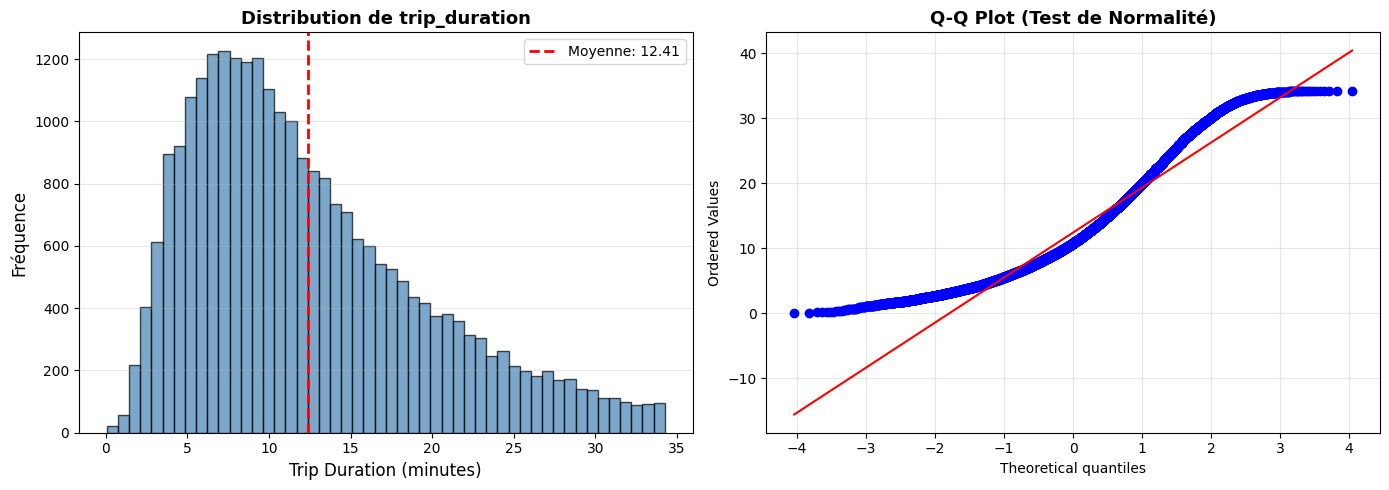

In [20]:
duration_sample = df_silver.select("trip_duration").sample(False, 0.01, seed=42).toPandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
axes[0].hist(duration_sample['trip_duration'], bins=50, color='steelblue', 
             alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Trip Duration (minutes)', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution de trip_duration', fontsize=13, fontweight='bold')
axes[0].axvline(duration_sample['trip_duration'].mean(), color='red', 
                linestyle='--', linewidth=2, label=f'Moyenne: {duration_sample["trip_duration"].mean():.2f}')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

from scipy import stats
stats.probplot(duration_sample['trip_duration'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot (Test de Normalité)', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
nbr = df_silver.count()
print(nbr)

2616166


#### CRÉATION DE FEATURES TEMPORELLES

In [22]:
df_silver = df_silver \
    .withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
    .withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime"))) \
    .withColumn("month", month(col("tpep_pickup_datetime"))) 

#### VALIDATION DE LA COHÉRENCE

In [23]:
df_silver = df_silver.withColumn(
    "is_amount_consistent",
    when(
        abs(col("total_amount") - 
            (col("fare_amount") + col("extra") + col("mta_tax") + 
             col("tip_amount") + col("tolls_amount") + 
             col("improvement_surcharge") + col("congestion_surcharge") + 
             col("Airport_fee") + col("cbd_congestion_fee"))) < 0.5,
        True
    ).otherwise(False)
)

inconsistent_amounts = df_silver.filter(col("is_amount_consistent") == False).count()
print(f"✓ Montants incohérents détectés: {inconsistent_amounts:,}")

✓ Montants incohérents détectés: 553,853


In [24]:
nb_row_silver = df_silver.count()
print(nb_row_silver)
print(df_silver.columns)

2616166
['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'trip_duration', 'outlier_type_iqr', 'pickup_hour', 'day_of_week', 'month', 'is_amount_consistent']


In [25]:
df_silver = df_silver.select(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee', 'cbd_congestion_fee', 'trip_duration', 'pickup_hour', 'day_of_week', 'month'])

### Visualisation

##### CALCUL DES CORRÉLATIONS AVEC trip_duration

In [26]:
numeric_features = [
    "trip_duration",
    "passenger_count",
    "trip_distance",
    "PULocationID",
    "DOLocationID",
    "fare_amount",
    "extra",
    "mta_tax",
    "tip_amount",
    "tolls_amount",
    "improvement_surcharge",
    "total_amount",
    "congestion_surcharge",
    "Airport_fee",
    "cbd_congestion_fee"
    ]

correlations = {}
for feature in numeric_features:
    corr = df_silver.stat.corr(feature, "trip_duration")
    correlations[feature] = corr
    

##### Trier par valeur absolue de corrélation

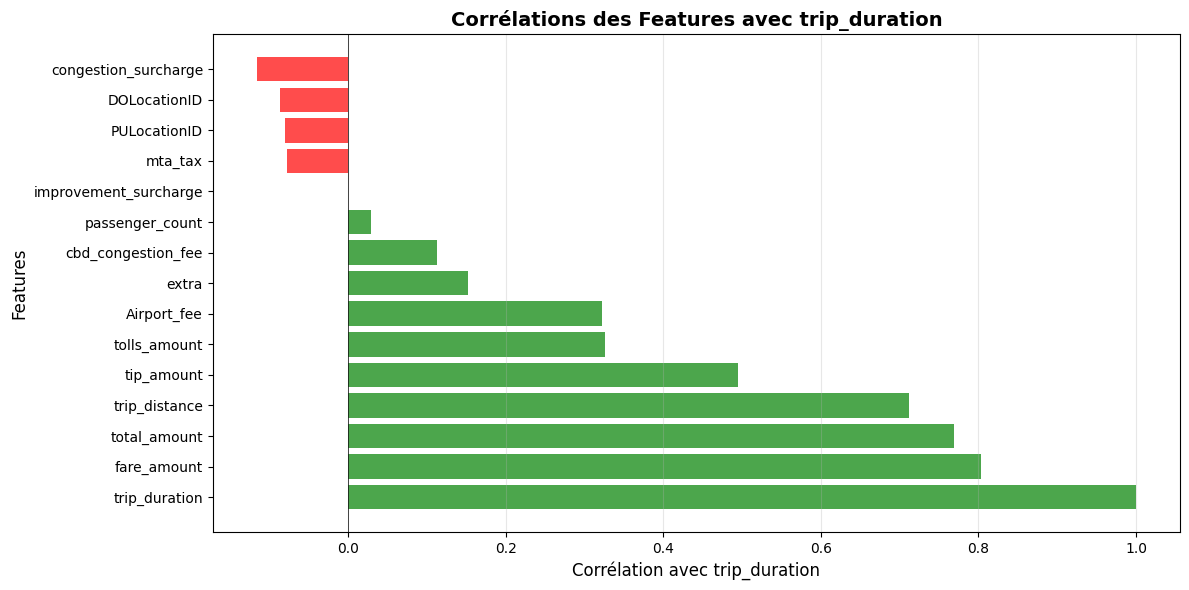

In [27]:
corr_df = pd.DataFrame(list(correlations.items()), 
                       columns=['Feature', 'Correlation'])
corr_df = corr_df.sort_values('Correlation', ascending=False)

# Graphique des corrélations
plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in corr_df['Correlation']]
plt.barh(corr_df['Feature'], corr_df['Correlation'], color=colors, alpha=0.7)
plt.xlabel('Corrélation avec trip_duration', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Corrélations des Features avec trip_duration', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

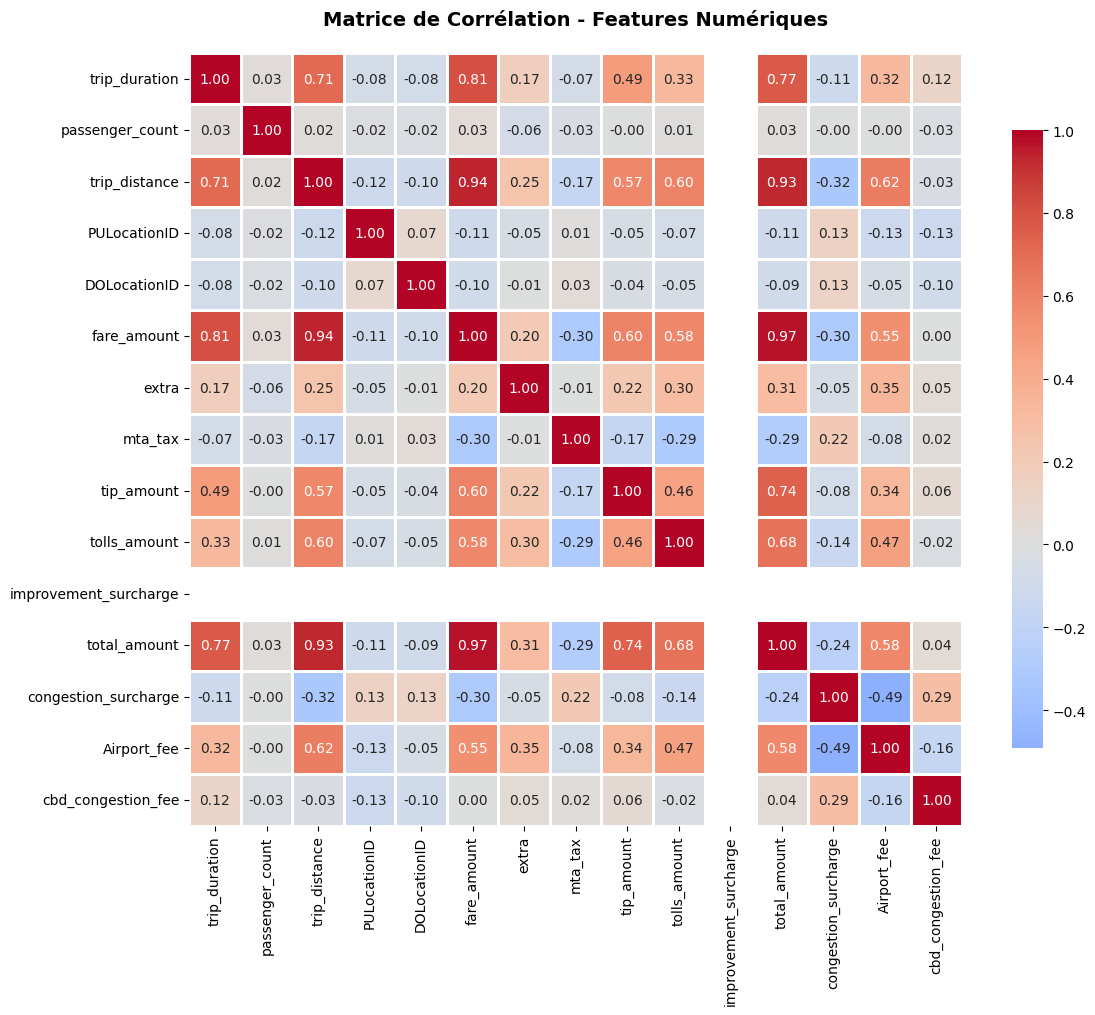

In [28]:

import seaborn as sns

# Échantillonner et convertir en pandas
df_corr = df_silver.select(numeric_features).sample(False, 0.01, seed=42).toPandas()

# Calculer la matrice de corrélation
corr_matrix = df_corr.corr()

# Visualiser
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation - Features Numériques', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

#### ANALYSE PAR VARIABLES CATÉGORIELLES

##### pickup_hour


⏰ ANALYSE PAR HEURE:


    pickup_hour  nb_trips  avg_duration  std_duration
0             0     62149     12.004102      7.214409
1             1     42488     11.561904      6.902131
2             2     28809     11.099062      6.615887
3             3     18585     11.076708      6.796372
4             4     11470     12.221777      7.866761
5             5     12921     11.637004      8.330162
6             6     30061     10.195641      6.846946
7             7     66694     10.935881      6.662020
8             8     97277     11.741985      6.857265
9             9    113039     12.273411      7.230254
10           10    123804     12.510361      7.326788
11           11    134366     12.679389      7.292327
12           12    145502     12.624539      7.271783
13           13    152809     12.838468      7.267472
14           14    162011     12.879695      7.299277
15           15    169304     12.693093      7.184015
16           16    171273     12.542169      7.157472
17           17    191326   

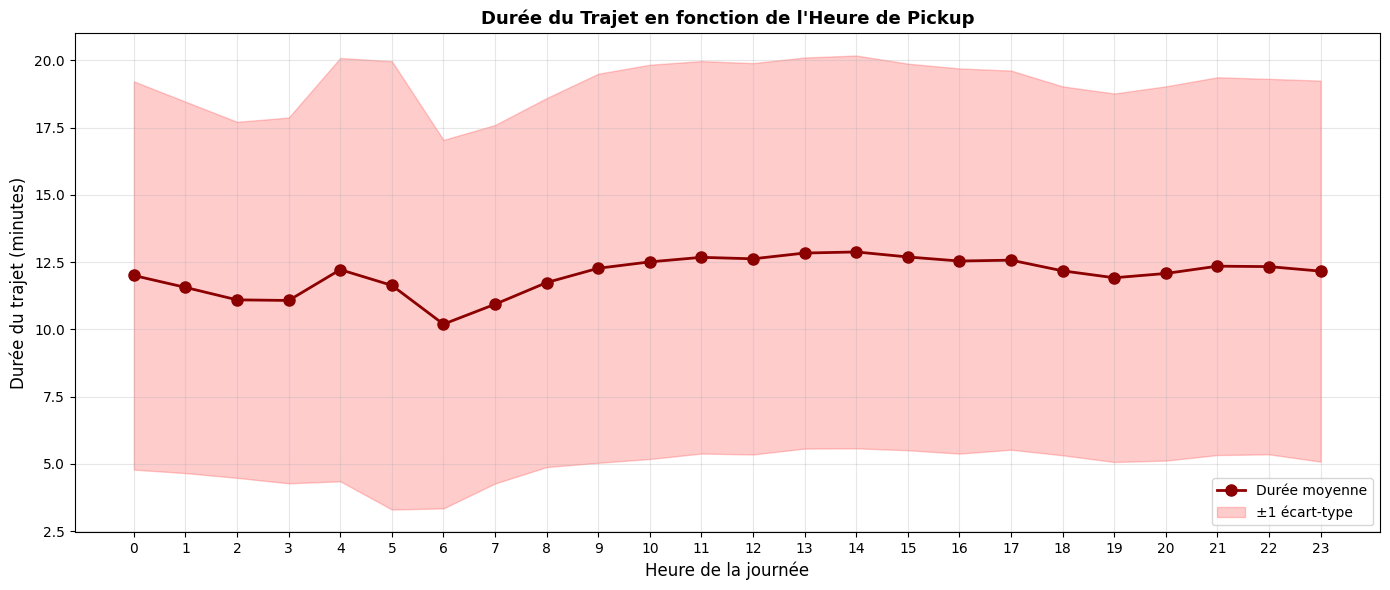

In [29]:
# --- pickup_hour ---
print("\n⏰ ANALYSE PAR HEURE:")
hourly_stats = df_silver.groupBy("pickup_hour").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("pickup_hour").toPandas()

print(hourly_stats)

# Créer la figure avec un seul subplot
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Durée moyenne par heure
ax.plot(hourly_stats['pickup_hour'], hourly_stats['avg_duration'], 
        marker='o', linewidth=2, markersize=8, color='darkred', label='Durée moyenne')
ax.fill_between(hourly_stats['pickup_hour'], 
                hourly_stats['avg_duration'] - hourly_stats['std_duration'],
                hourly_stats['avg_duration'] + hourly_stats['std_duration'],
                alpha=0.2, color='red', label='±1 écart-type')
ax.set_xlabel('Heure de la journée', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction de l\'Heure de Pickup', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xticks(range(0, 24))
ax.legend()

plt.tight_layout()
plt.show()

#### day_of_week

   day_of_week  nb_trips  avg_duration  std_duration day_name
0            1    291782     11.655777      7.038645      Dim
1            2    278727     11.933820      7.078485      Lun
2            3    347775     12.313880      7.038530      Mar
3            4    435018     12.497001      7.146716      Mer
4            5    460270     12.721810      7.187679      Jeu
5            6    436966     12.456792      7.097657      Ven
6            7    365628     12.163420      7.057473      Sam


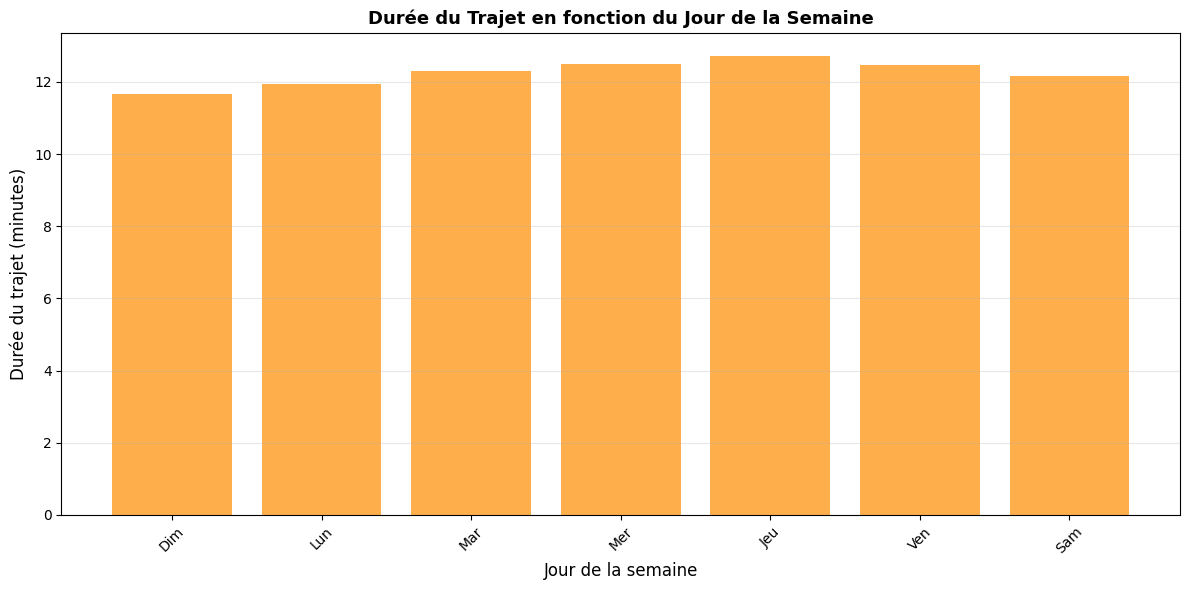

In [30]:
daily_stats = df_silver.groupBy("day_of_week").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("day_of_week").toPandas()

day_names = ['Dim', 'Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam']
daily_stats['day_name'] = daily_stats['day_of_week'].apply(lambda x: day_names[x-1])

print(daily_stats)

# Créer la figure avec un seul subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Durée moyenne par jour
ax.bar(daily_stats['day_name'], daily_stats['avg_duration'], 
       color='darkorange', alpha=0.7)
ax.set_xlabel('Jour de la semaine', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Jour de la Semaine', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Month


⏰ ANALYSE PAR MONTH:


   month  nb_trips  avg_duration  std_duration
0      1   2616146     12.305057      7.107147
1      2         1      4.666667           NaN
2     12        19     11.642105      6.988709


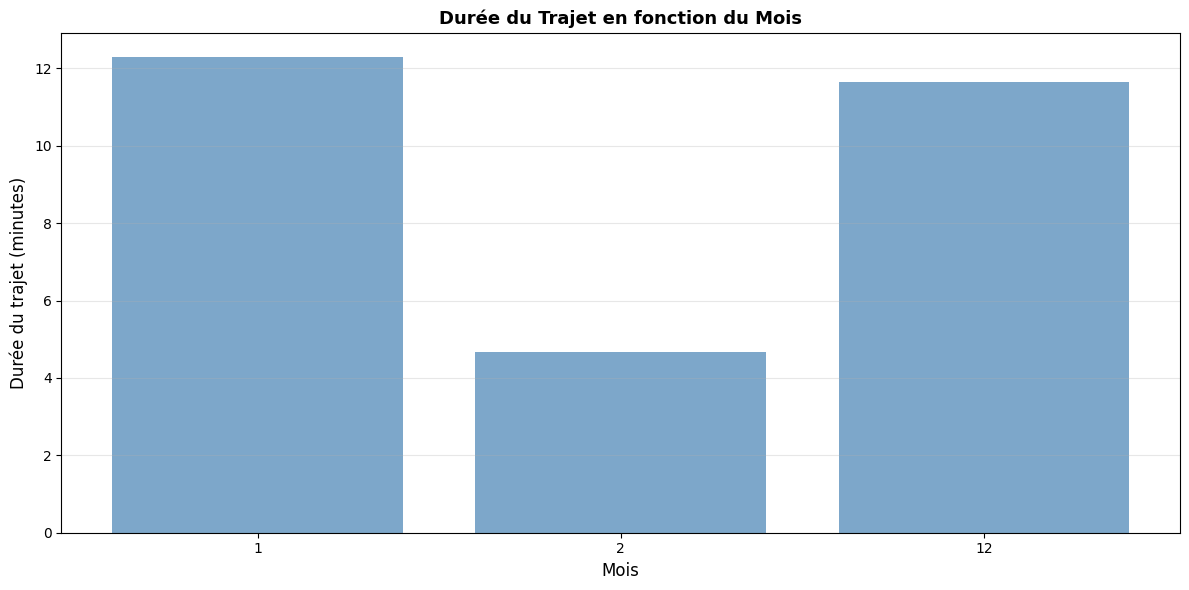

In [31]:
# --- Month ---
print("\n⏰ ANALYSE PAR MONTH:")
monthly_stats = df_silver.groupBy("month").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("month").toPandas()

print(monthly_stats)

# Créer la figure avec un seul subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Durée moyenne par Mois
ax.bar(monthly_stats['month'].astype(str), monthly_stats['avg_duration'], 
       color='steelblue', alpha=0.7)
ax.set_xlabel('Mois', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Mois', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


🚕 ANALYSE PAR VENDORID:


   VendorID  nb_trips  avg_duration  std_duration
0         1    562157     12.334805       6.98713
1         2   2054009     12.296906       7.13962


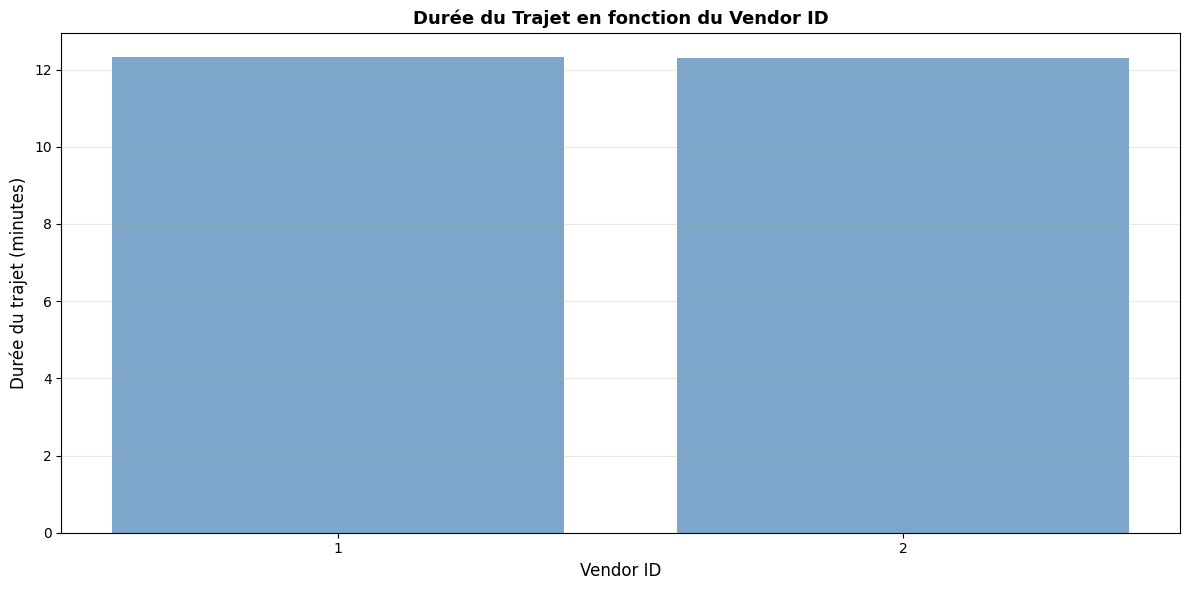


💵 ANALYSE PAR RATECODEID:


   RatecodeID  nb_trips  avg_duration  std_duration
0           1   2583384     12.149195      6.938427
1           2     16947     28.318665      6.815770
2           3      3957     25.555396      7.805393
3           4      3268     24.094441      6.130881
4           5      8603     16.997844     10.107884
5           6         7      0.733333      1.581607


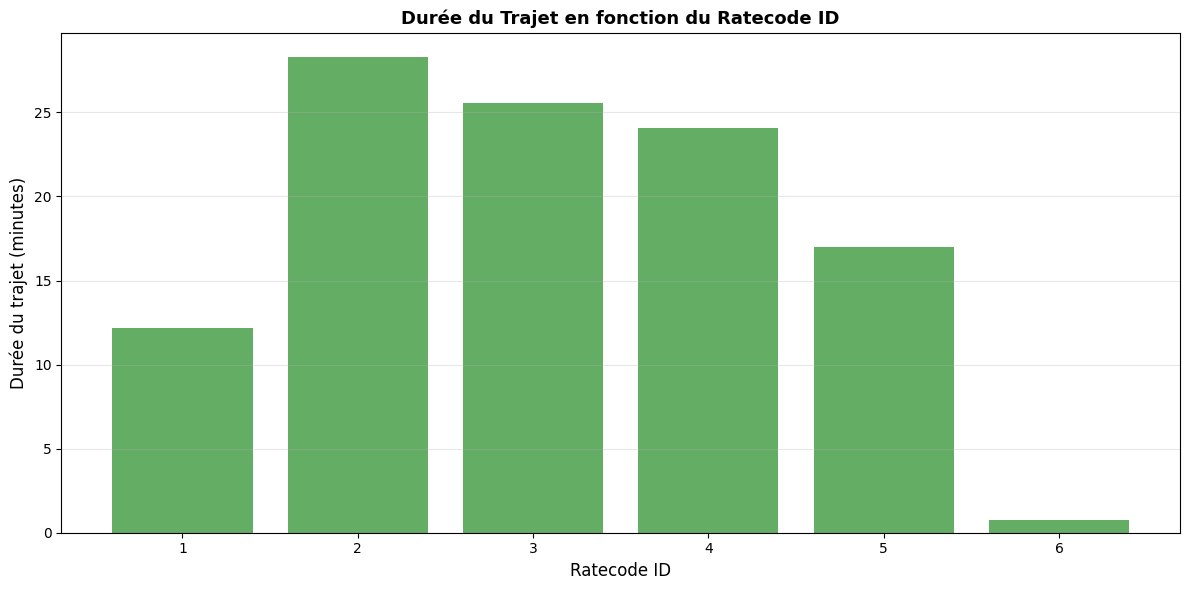


📦 ANALYSE PAR STORE_AND_FWD_FLAG:


  store_and_fwd_flag  nb_trips  avg_duration  std_duration
0                  N   2609651     12.305130      7.107453
1                  Y      6515     12.272732      6.982977


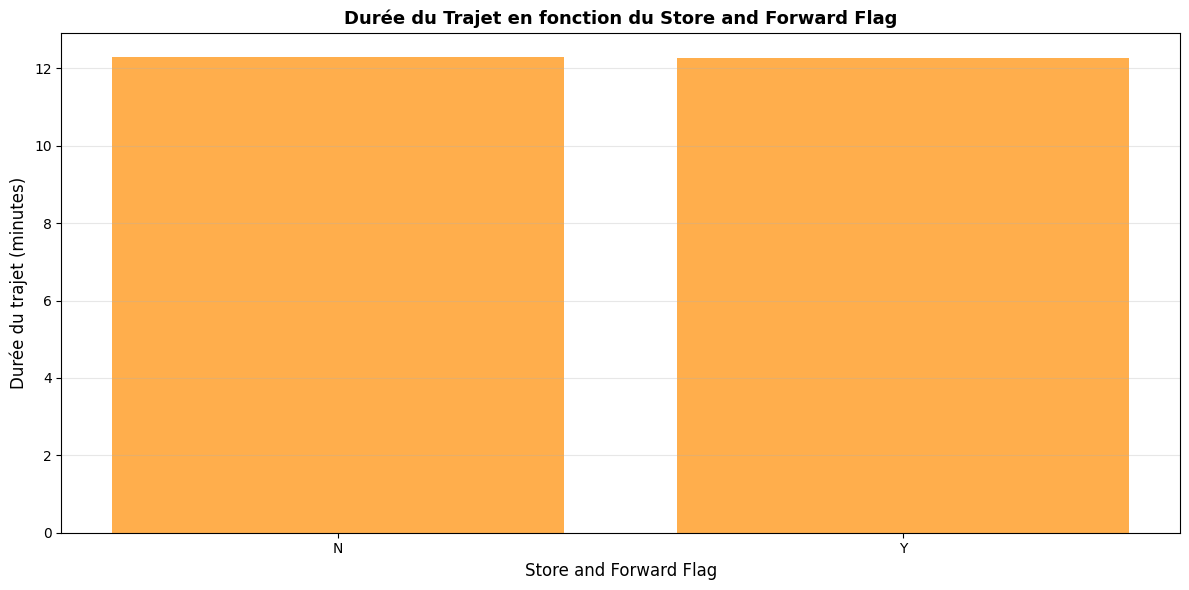


💳 ANALYSE PAR PAYMENT_TYPE:


   payment_type  nb_trips  avg_duration  std_duration
0             1   2236461     12.337698      7.083573
1             2    338370     12.135037      7.196141
2             3     10407     11.124836      7.522037
3             4     30928     12.201371      7.606801


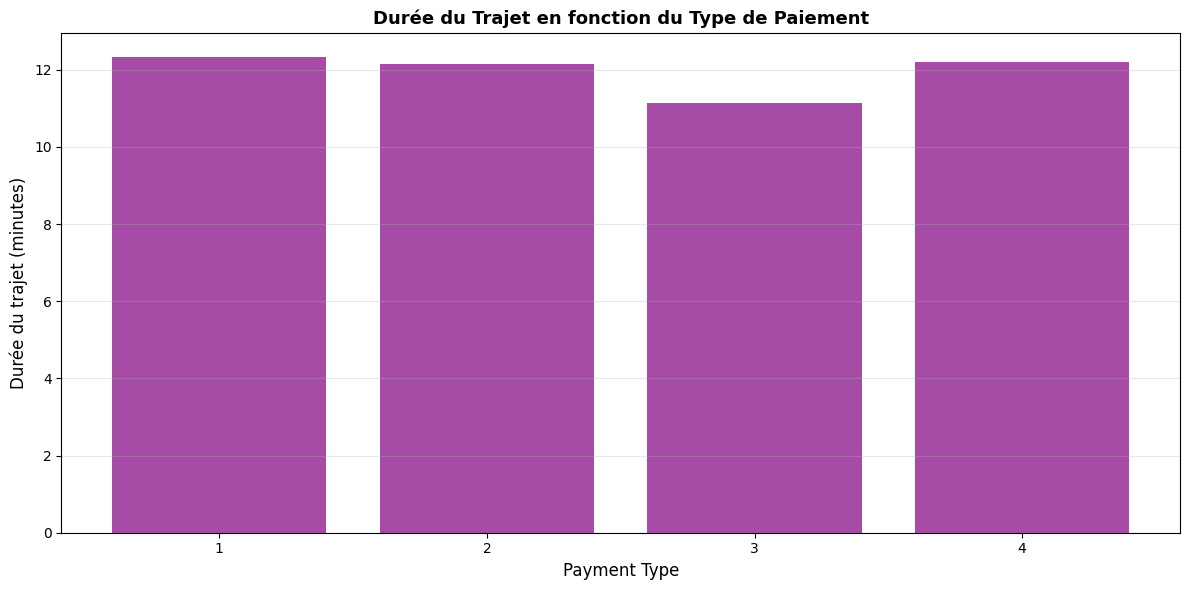

In [32]:
# --- vendorID ---
print("\n🚕 ANALYSE PAR VENDORID:")
vendor_stats = df_silver.groupBy("VendorID").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("VendorID").toPandas()

print(vendor_stats)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.bar(vendor_stats['VendorID'].astype(str), vendor_stats['avg_duration'], 
       color='steelblue', alpha=0.7)
ax.set_xlabel('Vendor ID', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Vendor ID', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# --- RatecodeID ---
print("\n💵 ANALYSE PAR RATECODEID:")
ratecode_stats = df_silver.groupBy("RatecodeID").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("RatecodeID").toPandas()

print(ratecode_stats)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.bar(ratecode_stats['RatecodeID'].astype(str), ratecode_stats['avg_duration'], 
       color='forestgreen', alpha=0.7)
ax.set_xlabel('Ratecode ID', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Ratecode ID', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# --- store_and_fwd_flag ---
print("\n📦 ANALYSE PAR STORE_AND_FWD_FLAG:")
store_stats = df_silver.groupBy("store_and_fwd_flag").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("store_and_fwd_flag").toPandas()

print(store_stats)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.bar(store_stats['store_and_fwd_flag'].astype(str), store_stats['avg_duration'], 
       color='darkorange', alpha=0.7)
ax.set_xlabel('Store and Forward Flag', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Store and Forward Flag', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


# --- payment_type ---
print("\n💳 ANALYSE PAR PAYMENT_TYPE:")
payment_stats = df_silver.groupBy("payment_type").agg(
    count("*").alias("nb_trips"),
    avg("trip_duration").alias("avg_duration"),
    stddev("trip_duration").alias("std_duration")
).orderBy("payment_type").toPandas()

print(payment_stats)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.bar(payment_stats['payment_type'].astype(str), payment_stats['avg_duration'], 
       color='purple', alpha=0.7)
ax.set_xlabel('Payment Type', fontsize=12)
ax.set_ylabel('Durée du trajet (minutes)', fontsize=12)
ax.set_title('Durée du Trajet en fonction du Type de Paiement', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

In [33]:
from pyspark.sql.functions import col, count

print("Distribution des valeurs de improvement_surcharge:")
df_silver.groupBy("improvement_surcharge").agg(
    count("*").alias("count")
).orderBy("improvement_surcharge").show()

Distribution des valeurs de improvement_surcharge:


+---------------------+-------+
|improvement_surcharge|  count|
+---------------------+-------+
|                  0.0|      4|
|                  1.0|2616162|
+---------------------+-------+



In [36]:
df_silver.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+-----------+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|     trip_duration|pickup_hour|day_of_week|month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+--

#### Sauvgarder silver data

In [34]:
# Nom de la table que vous voulez créer dans Postgres
table_name = "silver_data" 

try:
    # Sauvegarde des données
    df_silver.write.jdbc(
        url=url, 
        table=table_name, 
        mode="overwrite", # "overwrite" remplace la table, "append" ajoute à la suite
        properties=properties
    )
    print(f"✅ Données sauvegardées avec succès dans la table '{table_name}'")
except Exception as e:
    print(f"❌ Erreur lors de la sauvegarde : {e}")

✅ Données sauvegardées avec succès dans la table 'silver_data'


In [35]:
df_silver.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+-----------+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|     trip_duration|pickup_hour|day_of_week|month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+--